# Chap.10 ディープラーニングモデル

深層学習による数字認識モデル

In [1]:
# 必要ライブラリの宣言
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import warnings

warnings.filterwarnings('ignore')
rcParams['font.family'] = 'IPAexgothic'
# plt.style.use('ggplot')
plt.style.use('seaborn-darkgrid')
%matplotlib inline

## 10.1 例題の問題設定

## 10.2 モデルの構成と予測関数

## 10.3 損失関数

## 10.4 損失関数の微分計算

## 10.5 誤差逆伝播

## 10.6 勾配降下法の適用

## 10.7 プログラムの実装（その1）

データの読み込み

In [2]:
# データ読み込み
# 注意: 大量の学習データをインターネットからダウンロードするので、処理に数分かかります
# 2020-06-17 従来の方式で読み込みできなくなったので、新しい方式に切り替えました。

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1,)


In [3]:
# 新しい方式ではmnist.targetが文字列のため、コードを修正しています。
import pandas as pd

x_org, y_org = mnist.data, mnist.target.astype(np.int)

# 2021-06-27 sklearn 0.24.x対応
if type(x_org) == pd.core.frame.DataFrame:
    x_org = x_org.values
    y_org = y_org.values

入力データの加工

In [4]:
# 入力データの加工

# step1 データ正規化 値の範囲を[0, 1]とする
x_norm = x_org / 255.0

# 先頭にダミー変数(1)を追加
x_all = np.insert(x_norm, 0, 1, axis=1)

print('ダミー変数追加後', x_all.shape)

ダミー変数追加後 (70000, 785)


In [5]:
# step 2 yをOne-hot-Vectorに

from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)
y_all_one = ohe.fit_transform(np.c_[y_org])
print('One Hot Vector化後', y_all_one.shape)

One Hot Vector化後 (70000, 10)


In [6]:
# step 3 学習データ、検証データに分割

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test, y_train_one, y_test_one = train_test_split(
    x_all, y_org, y_all_one, train_size=60000, test_size=10000, shuffle=False)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape,
      y_train_one.shape, y_test_one.shape)

(60000, 785) (10000, 785) (60000,) (10000,) (60000, 10) (10000, 10)


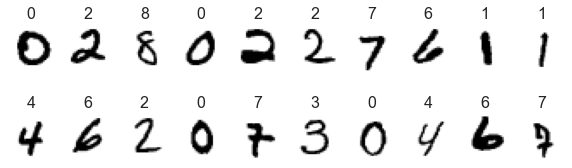

In [26]:
# データ内容の確認
# 2020-06-17
# 読み込み元データが変更になったため、図10-2、図10-9と画像が変わっています。

N = 20
np.random.seed(12)
indexes = np.random.choice(y_test.shape[0], N, replace=False)
x_selected = x_test[indexes, 1:]
y_selected = y_test[indexes]
plt.figure(figsize=(10, 3))
for i in range(N):
    # ax = plt.subplot(2, N/2, i + 1)
    ax = plt.subplot(2, N//2, i + 1)
    plt.imshow(x_selected[i].reshape(28, 28), cmap='gray_r')
    ax.set_title('%d' % y_selected[i], fontsize=16)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

予測関数

In [27]:
# シグモイド関数
def sigmoid(x):
    return 1/(1+ np.exp(-x))

In [28]:
# softmax関数
def softmax(x):
    x = x.T
    x_max = x.max(axis=0)
    x = x - x_max
    w = np.exp(x)
    return (w / w.sum(axis=0)).T


評価関数

In [29]:
# 交差エントロピー関数
def cross_entropy(yt, yp):
    return -np.mean(np.sum(yt * np.log(yp), axis=1))

In [30]:
# 評価処理 (戻り値は精度と損失関数)
from sklearn.metrics import accuracy_score


def evaluate(x_test, y_test, y_test_one, V, W):
    b1_test = np.insert(sigmoid(x_test @ V), 0, 1, axis=1)
    yp_test_one = softmax(b1_test @ W)
    yp_test = np.argmax(yp_test_one, axis=1)
    loss = cross_entropy(y_test_one, yp_test_one)
    score = accuracy_score(y_test, yp_test)
    return score, loss

ミニバッチ処理

In [31]:
# ミニバッチ用index取得関数
import numpy as np


class Indexes():

    # コンストラクタ
    def __init__(self, total, size):
        # 配列全体の大きさ
        self.total = total
        # batchサイズ
        self.size = size
        #　作業用indexes 初期値はNULLにしておく
        self.indexes = np.zeros(0)

    # index取得関数
    def next_index(self):
        next_flag = False

    # bacthサイズより作業用Indexesが小さい場合はindexes再生成
        if len(self.indexes) < self.size:
            self.indexes = np.random.choice(self.total,
                                            self.total, replace=False)
            next_flag = True

        # 戻り用index取得と作業用indexes更新
        index = self.indexes[:self.size]
        self.indexes = self.indexes[self.size:]
        return index, next_flag

In [32]:
# Indexesクラスのテスト

# クラス初期化
# 20: 全体の配列の大きさ
# 5: 一回に取得するindexの数
indexes = Indexes(20, 5)

for i in range(6):
    # next_index関数呼び出し
    # 戻り値1:  indexのnumpy配列
    # 戻り値2: 作業用Indexの更新があったかどうか
    arr, flag = indexes.next_index()
    print(arr, flag)

[11  3  9 17 12] True
[ 2  7 18  0  8] False
[ 1 16 10 14 15] False
[19  4  5 13  6] False
[12  5 18 15 10] True
[17 19  1  2  9] False


初期化処理（その1）

In [33]:
# 変数初期宣言 初期バージョン

# 隠れ層のノード数
H = 128
H1 = H + 1
# M: 訓練用系列データ総数
M = x_train.shape[0]
# D: 入力データ次元数
D = x_train.shape[1]
# N: 分類クラス数
N = y_train_one.shape[1]

# 繰り返し回数
nb_epoch = 100
# ミニバッチサイズ
batch_size = 512
B = batch_size
# 学習率
alpha = 0.01

# 重み行列の初期設定(すべて1)
V = np.ones((D, H))
W = np.ones((H1, N))

# 評価結果記録用 (損失関数値と精度)
history1 = np.zeros((0, 3))

# ミニバッチ用関数初期化
indexes = Indexes(M, batch_size)

# 繰り返し回数カウンタ初期化
epoch = 0

メイン処理

In [34]:
# メイン処理
while epoch < nb_epoch:

    # 学習対象の選択(ミニバッチ学習法)
    index, next_flag = indexes.next_index()
    x, yt = x_train[index], y_train_one[index]

    # 予測値計算 (順伝播)
    a = x @ V                         # (10.6.3)
    b = sigmoid(a)                    # (10.6.4)
    b1 = np.insert(b, 0, 1, axis=1)   # ダミー変数の追加
    u = b1 @ W                        # (10.6.5)
    yp = softmax(u)                   # (10.6.6)

    # 誤差計算
    yd = yp - yt                      # (10.6.7)
    bd = b * (1-b) * (yd @ W[1:].T)   # (10.6.8)

    # 勾配計算
    W = W - alpha * (b1.T @ yd) / B   # (10.6.9)
    V = V - alpha * (x.T @ bd) / B    # (10.6.10)

    # ログ記録用
    if next_flag:  # 1 epoch 終了後の処理
        score, loss = evaluate(
            x_test, y_test, y_test_one, V, W)
        history1 = np.vstack((history1,
                              np.array([epoch, loss, score])))
        print("epoch = %d loss = %f score = %f"
              % (epoch, loss, score))
        epoch = epoch + 1

epoch = 0 loss = 2.302684 score = 0.102800
epoch = 1 loss = 2.301634 score = 0.113500
epoch = 2 loss = 2.301854 score = 0.102800
epoch = 3 loss = 2.301373 score = 0.113500
epoch = 4 loss = 2.301066 score = 0.113500
epoch = 5 loss = 2.301543 score = 0.113500
epoch = 6 loss = 2.301131 score = 0.113500
epoch = 7 loss = 2.301606 score = 0.113500
epoch = 8 loss = 2.301661 score = 0.103200
epoch = 9 loss = 2.301806 score = 0.113500
epoch = 10 loss = 2.301595 score = 0.113500
epoch = 11 loss = 2.301835 score = 0.113500
epoch = 12 loss = 2.301385 score = 0.113500
epoch = 13 loss = 2.302149 score = 0.102800
epoch = 14 loss = 2.301034 score = 0.113500
epoch = 15 loss = 2.301517 score = 0.102800
epoch = 16 loss = 2.301389 score = 0.113500
epoch = 17 loss = 2.301642 score = 0.113500
epoch = 18 loss = 2.301591 score = 0.113500
epoch = 19 loss = 2.301194 score = 0.113500
epoch = 20 loss = 2.301207 score = 0.113500
epoch = 21 loss = 2.301246 score = 0.113500
epoch = 22 loss = 2.301616 score = 0.11350

結果の確認（その1）

In [35]:
#損失関数値と精度の確認
print('初期状態: 損失関数:%f 精度:%f' 
        % (history1[0,1], history1[0,2]))
print('最終状態: 損失関数:%f 精度:%f' 
        % (history1[-1,1], history1[-1,2]))

初期状態: 損失関数:2.302684 精度:0.102800
最終状態: 損失関数:2.301693 精度:0.113500


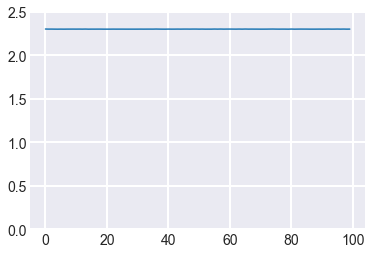

In [36]:
# 学習曲線の表示 (損失関数値)
plt.plot(history1[:, 0], history1[:, 1])
plt.ylim(0, 2.5)
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.show()

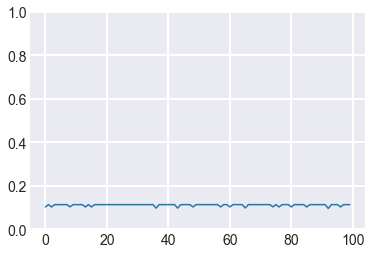

In [37]:
# 学習曲線の表示 (精度)
plt.plot(history1[:, 0], history1[:, 2])
plt.ylim(0, 1)
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.show()

## 10.8 プログラムの実装（その2）

重み行列の初期化の工夫

変数初期化（その2）

In [38]:
# 変数初期宣言 重み行列の初期化方式変更

# 隠れ層のノード数
H = 128
H1 = H + 1

# M: 訓練用系列データ総数
M = x_train.shape[0]

# D: 入力データ次元数
D = x_train.shape[1]

# N: 分類クラス数
N = y_train_one.shape[1]

# 機械学習パラメータ
alpha = 0.01
nb_epoch = 100
batch_size = 512
B = batch_size

# 重み行列の初期設定(すべて1)
V = np.ones((D, H))
W = np.ones((H1, N))

# 評価結果記録用 (損失関数値と精度)
history2 = np.zeros((0, 3))

# ミニバッチ用関数初期化
indexes = Indexes(M, batch_size)

# 繰り返し回数カウンタ初期化
epoch = 0

In [39]:
# 重み行列の初期設定改訂版
np.random.seed(123)
V = np.random.randn(D, H) / np.sqrt(D / 2)
W = np.random.randn(H1, N) / np.sqrt(H1 / 2)
print(V[:2,:5])
print(W[:2,:5])

[[-0.05479769  0.05034146  0.01428347 -0.0760309  -0.02920511]
 [ 0.02394289 -0.02846431 -0.05034025 -0.05552517 -0.03818151]]
[[-0.04639015  0.12208132 -0.09068864 -0.09727418 -0.10204216]
 [ 0.03651466  0.07946677 -0.28606743  0.05307577 -0.09380706]]


In [40]:
# メイン処理
while epoch < nb_epoch:

    # 学習対象の選択(ミニバッチ学習法)
    index, next_flag = indexes.next_index()
    x, yt = x_train[index], y_train_one[index]

    # 予測値計算 (順伝播)
    a = x @ V                         # (10.6.3)
    b = sigmoid(a)                    # (10.6.4)
    b1 = np.insert(b, 0, 1, axis=1)   # ダミー変数の追加
    u = b1 @ W                        # (10.6.5)
    yp = softmax(u)                   # (10.6.6)

    # 誤差計算
    yd = yp - yt                      # (10.6.7)
    bd = b * (1-b) * (yd @ W[1:].T)   # (10.6.8)

    # 勾配計算
    W = W - alpha * (b1.T @ yd) / B   # (10.6.9)
    V = V - alpha * (x.T @ bd) / B    # (10.6.10)

    if next_flag:  # 1epoch 終了後の処理
        score, loss = evaluate(
            x_test, y_test, y_test_one, V, W)
        history2 = np.vstack((history2,
                              np.array([epoch, loss, score])))
        print("epoch = %d loss = %f score = %f"
              % (epoch, loss, score))
        epoch = epoch + 1

epoch = 0 loss = 2.495346 score = 0.113300
epoch = 1 loss = 2.171611 score = 0.404600
epoch = 2 loss = 2.028254 score = 0.595200
epoch = 3 loss = 1.893397 score = 0.663100
epoch = 4 loss = 1.765260 score = 0.708200
epoch = 5 loss = 1.644877 score = 0.730500
epoch = 6 loss = 1.532679 score = 0.752400
epoch = 7 loss = 1.429361 score = 0.765900
epoch = 8 loss = 1.335575 score = 0.784200
epoch = 9 loss = 1.250557 score = 0.792100
epoch = 10 loss = 1.174610 score = 0.801800
epoch = 11 loss = 1.106852 score = 0.808100
epoch = 12 loss = 1.046480 score = 0.816700
epoch = 13 loss = 0.992841 score = 0.821500
epoch = 14 loss = 0.944938 score = 0.829100
epoch = 15 loss = 0.902200 score = 0.832200
epoch = 16 loss = 0.864133 score = 0.835700
epoch = 17 loss = 0.829652 score = 0.841200
epoch = 18 loss = 0.798712 score = 0.843800
epoch = 19 loss = 0.770707 score = 0.846500
epoch = 20 loss = 0.745329 score = 0.849300
epoch = 21 loss = 0.722188 score = 0.852000
epoch = 22 loss = 0.701061 score = 0.85510

結果の確認（その2）

In [41]:
#損失関数値と精度の確認
print('初期状態: 損失関数:%f 精度:%f' 
        % (history2[0,1], history2[0,2]))
print('最終状態: 損失関数:%f 精度:%f' 
        % (history2[-1,1], history2[-1,2]))

初期状態: 損失関数:2.495346 精度:0.113300
最終状態: 損失関数:0.347606 精度:0.903700


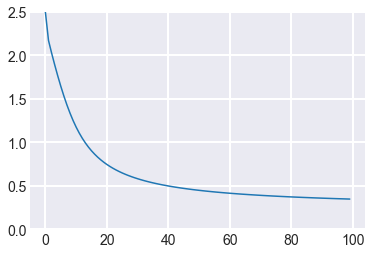

In [42]:
# 学習曲線の表示 (損失関数値)
plt.plot(history2[:, 0], history2[:, 1])
plt.ylim(0, 2.5)
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.show()

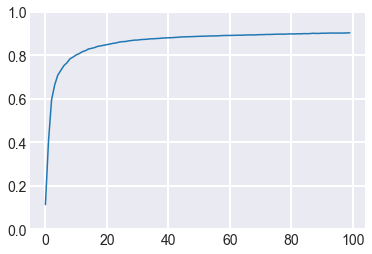

In [43]:
# 学習曲線の表示 (精度)
plt.plot(history2[:, 0], history2[:, 2])
plt.ylim(0, 1)
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.show()

## 10.9 プログラムの実装（その3）

ReLU関数の導入

In [44]:
# ReLU関数
def ReLU(x):
    return np.maximum(0, x)

In [45]:
# step関数
def step(x):
    return 1.0 * ( x > 0)

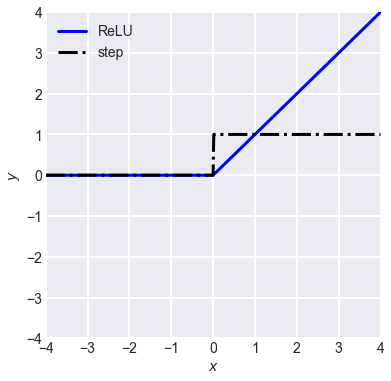

In [46]:
# ReLU関数とstep関数のグラフ表示

xx = np.linspace(-4, 4, 501)
yy = ReLU(xx)
plt.figure(figsize=(6, 6))
#plt.ylim(0.0, 1.0)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.xlabel(r'$x$', fontsize=14)
plt.ylabel(r'$y$', fontsize=14)
plt.grid(lw=2)
plt.plot(xx, ReLU(xx), c='b', label='ReLU', linestyle='-', lw=3)
plt.plot(xx, step(xx), c='k', label='step', linestyle='-.', lw=3)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(fontsize=14)
plt.show()


評価（その2）

In [47]:
# 評価処理 (ReLU関数対応版)
from sklearn.metrics import accuracy_score


def evaluate2(x_test, y_test, y_test_one, V, W):
    b1_test = np.insert(ReLU(x_test @ V), 0, 1, axis=1)
    yp_test_one = softmax(b1_test @ W)
    yp_test = np.argmax(yp_test_one, axis=1)
    loss = cross_entropy(y_test_one, yp_test_one)
    score = accuracy_score(y_test, yp_test)
    return score, loss

初期化処理

In [48]:
# 変数初期宣言 重み行列の初期化方式変更
# 隠れ層のノード数
H = 128
H1 = H + 1
# M: 訓練用系列データ総数
M = x_train.shape[0]

# D: 入力データ次元数
D = x_train.shape[1]

# N: 分類クラス数
N = y_train_one.shape[1]

# 機械学習パラメータ
alpha = 0.01
nb_epoch = 100
batch_size = 512
B = batch_size

# 重み行列の初期設定
np.random.seed(123)
V = np.random.randn(D, H) / np.sqrt(D / 2)
W = np.random.randn(H1, N) / np.sqrt(H1 / 2)

# 評価結果記録用 (損失関数値と精度)
history3 = np.zeros((0, 3))

# ミニバッチ用関数初期化
indexes = Indexes(M, batch_size)

# 繰り返し回数カウンタ初期化
epoch = 0

メイン処理

In [49]:
# メイン処理 (シグモイド関数をLeRU関数に変更)
while epoch < nb_epoch:

    # 学習対象の選択(ミニバッチ学習法)
    index, next_flag = indexes.next_index()
    x, yt = x_train[index], y_train_one[index]

    # 予測値計算 (順伝播)
    a = x @ V                         # (10.6.3)
    b = ReLU(a)                       # (10.6.4) ReLU化
    b1 = np.insert(b, 0, 1, axis=1)   # ダミー変数の追加
    u = b1 @ W                        # (10.6.5)
    yp = softmax(u)                   # (10.6.6)

    # 誤差計算
    yd = yp - yt                      # (10.6.7)
    bd = step(a) * (yd @ W[1:].T)  # (10.6.8) ReLU化

    # 勾配計算
    W = W - alpha * (b1.T @ yd) / B   # (10.6.9)
    V = V - alpha * (x.T @ bd) / B    # (10.6.10)

    if next_flag:  # 1epoch 終了後の処理
        score, loss = evaluate2(
            x_test, y_test, y_test_one, V, W)
        history3 = np.vstack((history3,
                              np.array([epoch, loss, score])))
        print("epoch = %d loss = %f score = %f"
              % (epoch, loss, score))
        epoch = epoch + 1

epoch = 0 loss = 2.436569 score = 0.054900
epoch = 1 loss = 1.502820 score = 0.697100
epoch = 2 loss = 1.016633 score = 0.795400
epoch = 3 loss = 0.780017 score = 0.834200
epoch = 4 loss = 0.652700 score = 0.856000
epoch = 5 loss = 0.575315 score = 0.866000
epoch = 6 loss = 0.522856 score = 0.873100
epoch = 7 loss = 0.485339 score = 0.879100
epoch = 8 loss = 0.457101 score = 0.884600
epoch = 9 loss = 0.434487 score = 0.888400
epoch = 10 loss = 0.416343 score = 0.891400
epoch = 11 loss = 0.401457 score = 0.893900
epoch = 12 loss = 0.388552 score = 0.896400
epoch = 13 loss = 0.378025 score = 0.898200
epoch = 14 loss = 0.368038 score = 0.900200
epoch = 15 loss = 0.359661 score = 0.901400
epoch = 16 loss = 0.352465 score = 0.904000
epoch = 17 loss = 0.345642 score = 0.905600
epoch = 18 loss = 0.339355 score = 0.906800
epoch = 19 loss = 0.334006 score = 0.908300
epoch = 20 loss = 0.328981 score = 0.909000
epoch = 21 loss = 0.323938 score = 0.910700
epoch = 22 loss = 0.320040 score = 0.91130

結果の確認（その3）

In [50]:
#損失関数値と精度の確認
print('初期状態: 損失関数:%f 精度:%f' 
        % (history3[0,1], history3[0,2]))
print('最終状態: 損失関数:%f 精度:%f' 
        % (history3[-1,1], history3[-1,2]))

初期状態: 損失関数:2.436569 精度:0.054900
最終状態: 損失関数:0.199998 精度:0.943100


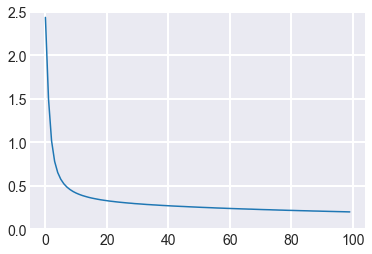

In [51]:
# 学習曲線の表示 (損失関数値)
plt.plot(history3[:, 0], history3[:, 1])
plt.ylim(0, 2.5)
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.show()

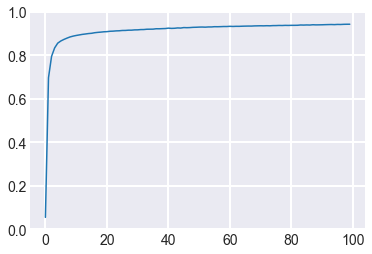

In [52]:
# 学習曲線の表示 (精度)
plt.plot(history3[:, 0], history3[:, 2])
plt.ylim(0, 1)
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.show()

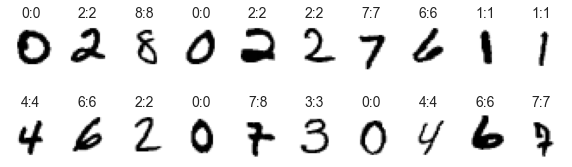

In [53]:
# データ内容の確認
# 2020-06-17
# 読み込みデータが変わったため、図10-22と画像が変わっています。

import matplotlib.pyplot as plt

N = 20
np.random.seed(12)
indexes = np.random.choice(y_test.shape[0], N, replace=False)

# x_orgの選択結果表示 (白黒反転)
x_selected = x_test[indexes]
y_selected = y_test[indexes]

# 予測値の計算
b1_test = np.insert(ReLU(x_selected @ V), 0, 1, axis=1)
yp_test_one = softmax(b1_test @ W)
yp_test = np.argmax(yp_test_one, axis=1)

# グラフ表示
plt.figure(figsize=(10, 3))
for i in range(N):
    # ax = plt.subplot(2, N/2, i + 1)
    ax = plt.subplot(2, N//2, i + 1)
    plt.imshow(x_selected[i, 1:].reshape(28, 28), cmap='gray_r')
    ax.set_title('%d:%d' % (y_selected[i], yp_test[i]), fontsize=14)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


## 10.10 プログラムの実装（その4）

隠れ層の2層化

評価

In [54]:
# 評価処理 (隠れ層2階層対応版)
from sklearn.metrics import accuracy_score


def evaluate3(x_test, y_test, y_test_one, U, V, W):
    b1_test = np.insert(ReLU(x_test @ U), 0, 1, axis=1)
    d1_test = np.insert(ReLU(b1_test @ V), 0, 1, axis=1)
    yp_test_one = softmax(d1_test @ W)
    yp_test = np.argmax(yp_test_one, axis=1)
    loss = cross_entropy(y_test_one, yp_test_one)
    score = accuracy_score(y_test, yp_test)
    return score, loss

初期化処理（その3）

In [55]:
# 変数初期宣言 重み行列の初期化方式変更
# 隠れ層のノード数
H = 128
H1 = H + 1
# M: 訓練用系列データ総数
M = x_train.shape[0]

# D: 入力データ次元数
D = x_train.shape[1]

# N: 分類クラス数
N = y_train_one.shape[1]

# 機械学習パラメータ
alpha = 0.01
nb_epoch = 200
batch_size = 512
B = batch_size

# 重み行列の初期設定
np.random.seed(123)
U = np.random.randn(D, H) / np.sqrt(D / 2)
V = np.random.randn(H1, H) / np.sqrt(H1 / 2)
W = np.random.randn(H1, N) / np.sqrt(H1 / 2)

# 評価結果記録用 (損失関数値と精度)
history4 = np.zeros((0, 3))

# ミニバッチ用関数初期化
indexes = Indexes(M, batch_size)

# 繰り返し回数カウンタ初期化
epoch = 0

メイン処理（その4）

In [56]:
# メイン処理 (隠れ層2層化)

while epoch < nb_epoch:
    # 学習対象の選択(ミニバッチ学習法)
    index, next_flag = indexes.next_index()
    x, yt = x_train[index], y_train_one[index]

    # 予測値計算 (順伝播)
    a = x @ U                        # (10.6.11)
    b = ReLU(a)                      # (10.6.12)
    b1 = np.insert(b, 0, 1, axis=1)  # ダミー変数の追加
    c = b1 @ V                       # (10.6.13)
    d = ReLU(c)                      # (10.6.14)
    d1 = np.insert(d, 0, 1, axis=1)  # ダミー変数の追加
    u = d1 @ W                       # (10.6.15)
    yp = softmax(u)                  # (10.6.16)

    # 誤差計算
    yd = yp - yt                     # (10.6.17)
    dd = step(c) * (yd @ W[1:].T)    # (10.6.18)
    bd = step(a) * (dd @ V[1:].T)    # (10.6.19)

    # 勾配計算
    W = W - alpha * (d1.T @ yd) / B  # (10.6.20)
    V = V - alpha * (b1.T @ dd) / B  # (10.6.21)
    U = U - alpha * (x.T @ bd) / B   # (10.6.22)

    if next_flag:  # 1epoch 終了後の処理
        score, loss = evaluate3(
            x_test, y_test, y_test_one, U, V, W)
        history4 = np.vstack((history4,
                              np.array([epoch, loss, score])))
        print("epoch = %d loss = %f score = %f"
              % (epoch, loss, score))
        epoch = epoch + 1

epoch = 0 loss = 2.404732 score = 0.095700
epoch = 1 loss = 1.390761 score = 0.731900
epoch = 2 loss = 0.809097 score = 0.826400
epoch = 3 loss = 0.598449 score = 0.854100
epoch = 4 loss = 0.501668 score = 0.870400
epoch = 5 loss = 0.446378 score = 0.882800
epoch = 6 loss = 0.410481 score = 0.890000
epoch = 7 loss = 0.385008 score = 0.894700
epoch = 8 loss = 0.365350 score = 0.899400
epoch = 9 loss = 0.350588 score = 0.901500
epoch = 10 loss = 0.337182 score = 0.906500
epoch = 11 loss = 0.326095 score = 0.908700
epoch = 12 loss = 0.317588 score = 0.910200
epoch = 13 loss = 0.308781 score = 0.912700
epoch = 14 loss = 0.301556 score = 0.915000
epoch = 15 loss = 0.294916 score = 0.916500
epoch = 16 loss = 0.289156 score = 0.918200
epoch = 17 loss = 0.283575 score = 0.919900
epoch = 18 loss = 0.278465 score = 0.921500
epoch = 19 loss = 0.274578 score = 0.922500
epoch = 20 loss = 0.270068 score = 0.922700
epoch = 21 loss = 0.264701 score = 0.925300
epoch = 22 loss = 0.261377 score = 0.92540

結果の確認

In [57]:
#損失関数値と精度の確認
print('初期状態: 損失関数:%f 精度:%f' 
    % (history4[1,1], history4[1,2]))
print('最終状態: 損失関数:%f 精度:%f' 
    % (history4[-1,1], history4[-1,2]))

初期状態: 損失関数:1.390761 精度:0.731900
最終状態: 損失関数:0.098557 精度:0.971100


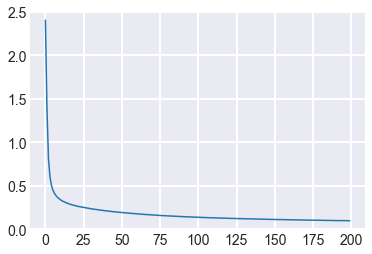

In [58]:
# 学習曲線の表示 (損失関数値)
plt.plot(history4[:, 0], history4[:, 1])
plt.ylim(0, 2.5)
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.show()

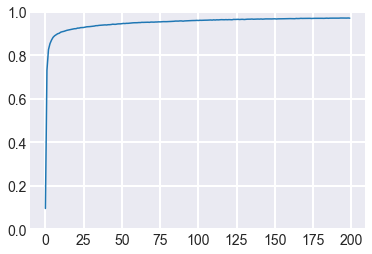

In [59]:
# 学習曲線の表示 (精度)
plt.plot(history4[:, 0], history4[:, 2])
plt.ylim(0, 1)
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.show()

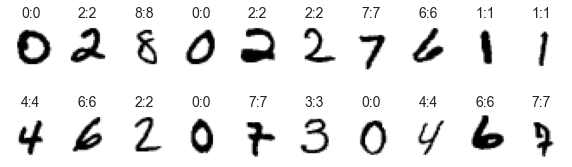

In [61]:
# データ内容の確認
# 2020-06-17
# 読み込みデータが変わったため、図10-26と画像が変わっています。

import matplotlib.pyplot as plt

N = 20
np.random.seed(12)
indexes = np.random.choice(y_test.shape[0], N, replace=False)

# x_orgの選択結果表示 (白黒反転)
x_selected = x_test[indexes]
y_selected = y_test[indexes]

# 予測値の計算
b1_test = np.insert(ReLU(x_selected @ U), 0, 1, axis=1)
d1_test = np.insert(ReLU(b1_test @ V), 0, 1, axis=1)
yp_test_one = softmax(d1_test @ W)
yp_test = np.argmax(yp_test_one, axis=1)

# グラフ表示
plt.figure(figsize=(10, 3))
for i in range(N):
    # ax = plt.subplot(2, N/2, i + 1)
    ax = plt.subplot(2, N//2, i + 1)
    plt.imshow(x_selected[i, 1:].reshape(28, 28), cmap='gray_r')
    ax.set_title('%d:%d' % (y_selected[i], yp_test[i]), fontsize=14)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()